In [1]:
import math
import lmfit
import json
import os
import numpy as np
import pandas as pd
from pandas import Series
from scipy import optimize
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq

In [2]:
def union_data(x_data, y_data, posi):
    """
    间隔为0.2
    """
    interval = 0.2
    X = []
    Y = []
    if posi == 1:
        x_y = {round(i, 1): [] for i in np.arange(0, 6.4 + interval, interval)}
    elif posi == -1:
        x_y = {round(i, 1): [] for i in np.arange(-8.0, interval, interval)}
    
    for x, y in zip(x_data, y_data):
        k = round(int(x / interval) * interval, 1) # 取 interval
        try:
            x_y[k].append(y)
        except:
            pass
    
    for x in x_y:
        y_list = x_y[x]
        if y_list:
            y = np.array(y_list).mean()
        else:
            y = -1
#         x_y[x] = y
        X.append(x)
        Y.append(y)
    
    last = 10000
    for i in range(len(Y)): 
        if Y[i] != -1:
            last = Y[i]
        if Y[i] == -1: # 找到第一个0
            for j in range(i+1, len(Y)): 
                if Y[j] != -1: # 找到最近的一个非0
                    now = Y[j]
                    break
            else:
                for m in range(i, len(Y)):
                    Y[m] = last
                return X, Y

            gap = (now - last) / (j - i + 1)
            for k in range(i, j):
                Y[k] = last + gap * (k - i + 1)
    return X, Y


def my_line(x_n, y_n, x, y, **kw):
    '''
    牛熊市下用户行为的差异
    :param x_n: 收益率小于0
    :param y_n:
    :param x: 收益率大于0
    :param y:
    :return:
    '''

    def linear(input_x, input_y):
        '''
        线性回归
        :param x:
        :param y:
        :return: 拟合参数
        '''
        clf = LinearRegression()
        X = [[i] for i in input_x.tolist()]
        y = input_y.tolist()
        clf.fit(X, y)
        return clf.coef_[0], clf.intercept_, clf.score(X, y)
    
    def liner_model(k, b):
        def model(x):
            return b + k * x
        return model
    
    
    res = {}
    plt.figure(figsize=(9, 5))
    
    plt.scatter(x_n, y_n, alpha=0.3, c = '#4ea64e', label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, c = '#fb5050',label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    #plt.plot(union_x_n, union_y_n, c='grey')
    #plt.plot(union_x, union_y, c='grey')
    
    
    # 正
    print('return > 0')
    
    # 画拟合直线
    print('---------- 收益率 < 0 ----------')
    a_n, b_n, r2 = linear(x_n, y_n)
    print('相关性：', x_n.corr(y_n))
    print('参数：', a_n, b_n)
    res['k_n'] = a_n
    res['b_n'] = b_n
    print('R^2：', r2)
    mod_n = liner_model(a_n, b_n)
    p_0 = mod_n(0)
    p_8 = mod_n(-8)
    p_4 = mod_n(4)
    plt.plot([-8, 0], [p_8, p_0], '-', c = '#008000', linewidth=2)
    plt.plot([0, 4], [p_0, p_4], '--', c = '#008000', linewidth=2)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', 1000), ('b', 1000))
    def residual(p):
        return p['k'] * x_n + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))

    print('---------- 收益率 > 0 ----------')
    a, b, r2 = linear(x, y)
    print('相关性：', x.corr(y))
    print('参数：', a, b)
    res['k'] = a
    res['b'] = b
    print('R^2：', r2)
    mod = liner_model(a, b)
    p_0 = mod(0)
    p_8 = mod(8)
    plt.plot([0, 8], [p_0, p_8], '-',c = '#ff0000',linewidth=1.8)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', -1000), ('b', 1000))
    def residual(p):
        return p['k'] * x + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    
    
    print('- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -')
    print('斜率比例：', a_n / a)
    the_point = (b - b_n) / (a_n - a)
    print('平衡点：', the_point)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    plt.scatter(the_point, mod(the_point), c='k', linewidths=3, zorder=100, label='balance point')
    
    plt.xlim(-9, 9)
    plt.xlabel('$r$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('amount of tweets', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.savefig('C:/Users/Lenovo/Desktop/su_image.svg')
    plt.show()
    plt.close('all')
    
    
    # -----------------------------------------------------
    
    print('收益率为0：', mod_n(0) / mod(0))
    print('收益率为1：', mod_n(-1) / mod(1))
    print('收益率为2：', mod_n(-2) / mod(2))
    print('收益率为4：', mod_n(-4) / mod(4))
    print('收益率为6：', mod_n(-6) / mod(6))
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_n(-i) / mod(i) for i in x]
    res['y_ratio'] = y
    plt.plot(x, y)
    plt.show()
    plt.close('all')
    
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    len_union_x = len(union_x)
#     print(union_x_n, union_y_n)
#     print(union_x, union_y)
    union_y_n.reverse()
    union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]
    res['union_y_ratio'] = union_ratio
    res['union_x'] = union_x
    plt.plot(union_x, union_ratio)
#     plt.legend(loc=1)
    plt.show()
    plt.close('all')
    
    res['union_y_n'] = union_y_n
    res['union_y'] = union_y 
    
    
    # 返回可以评估
    res['ratio'] = a_n / a
    res['point'] = the_point
    

    
    return res
    

    

In [3]:
def my_nonlinear_model(p):
    def this_model(x):
        return p['A1'] * (x ** p['A2']) + p['b']
    return this_model


def my_nonline(x_n, y_n, x, y, **kw):
    """
    拟合损失厌恶曲线
    注意：需要初始化参数
    """
    plt.figure(figsize=(12, 5))
    plt.scatter(x_n, y_n, alpha=0.3, label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    plt.plot(union_x_n, union_y_n, c='grey')
    plt.plot(union_x, union_y, c='grey')
    
    # 正
    print('return > 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', 1000), ('A2', 1), ('b', 4000))
    def residual(p):
        return p['A1'] * (x ** p['A2']) + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci1 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci1)
    
    mod_1 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 6, 0.1)
    y_fit = [mod_1(x) for x in x_fit]
    plt.plot(x_fit, y_fit, 'r-', linewidth=2)

    print('- * - ' * 15)

    # 负
    print('return < 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', -kw['k_n']), ('A2', 1.5), ('b', kw['b_n']))
    x_n = [-x for x in x_n]
    def residual(p):
        return p['A1'] * (x_n ** p['A2']) + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci2 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci2)

    mod_2 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 8, 0.1)
    y_fit = [mod_2(x) for x in x_fit]
    x_fit = [-x for x in x_fit]
    plt.plot(x_fit, y_fit, '-', c='purple', linewidth=2)
    
    
    # 画图配置及输出
    plt.xlim(-9, 9)
    plt.xlabel('$r$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('amount of tweets', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.show()
    plt.close('all')
    
    # 比值
    print('收益率为0.5：', mod_2(0.5) / mod_1(0.5))
    print('收益率为1：', mod_2(1) / mod_1(1))
    print('收益率为2：', mod_2(2) / mod_1(2))
    print('收益率为4：', mod_2(4) / mod_1(4))
    print('收益率为6：', mod_2(6) / mod_1(6))
    

    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_2(i) / mod_1(i) for i in x]
    kw['non_y_ratio'] = y
    plt.plot(np.arange(0, 10, 1), [1] * 10)
    plt.plot(x, y)
    plt.plot(kw['union_x'], kw['union_y_ratio'])
#     plt.legend(loc=1)
    plt.plot(np.arange(0, 10, 1), [1] * 10, alpha=0.1, linewidth=4)
    plt.show()
    plt.close('all')
    
    return kw



In [4]:
# 合并线性和非线性分析

def my_analysis(x_n, y_n, x, y, **kw):
    res = my_line(x_n, y_n, x, y, **kw)
    res = dict(kw, **res)
    res = my_nonline(x_n, y_n, x, y, **res)
    return res

城市群的角度计算损失厌恶

In [5]:
olhc_urban = pd.read_csv('C:/Users/Lenovo/yan/D/金融数据整理（2021）/bmgl/province/olhc_urban_agglomeration.csv')
olhc_urban.head()

,Date,open,high,low,close,volume,Beijing_Tianjin_Hebei,Yangtze_River_Delta,Pearl_River_Delta,Middle_Reaches_of_Yangtze_River,Chengdu_Chongqing,Harbin_Changchun,Central_Plains,Guangdong_HongKong_Macao_Greater_Bay_Area
0,2014/12/2,-0.4820,3.6047,-0.5616,3.08,437700,4337,4258,2271,1745,622,252,634,2517
1,2014/12/3,0.1940,2.2025,-1.0657,0.59,562100,4625,4916,2911,1891,842,308,783,3150
2,2014/12/4,0.1343,4.3447,-0.2628,4.34,532700,7220,7580,4133,2687,1373,471,1191,4471
3,2014/12/5,0.9037,2.6778,-3.0103,1.32,640500,7233,6898,3809,2729,1209,428,1155,4147
4,2014/12/8,-1.0537,3.5006,-2.0054,2.82,587600,5999,5533,3460,2170,1072,369,954,3794


收益率与中原城市群
return > 0
---------- 收益率 < 0 ----------
相关性： -0.2619346564375826
参数： -93.58474810154769 1414.0781491400764
R^2： 0.0686097642430743
[[Variables]]
    k: -93.5847481 +/- 24.8198583 (26.52%) (init = 1000)
    b:  1414.07815 +/- 61.9089826 (4.38%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.021463428860013366
参数： 10.062736839701756 1344.8770869629739
R^2： 0.00046067877842881355
[[Variables]]
    k:  10.0627368 +/- 29.4684069 (292.85%) (init = -1000)
    b:  1344.87709 +/- 53.8053051 (4.00%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -9.300128741548347
平衡点： 0.667657900395054


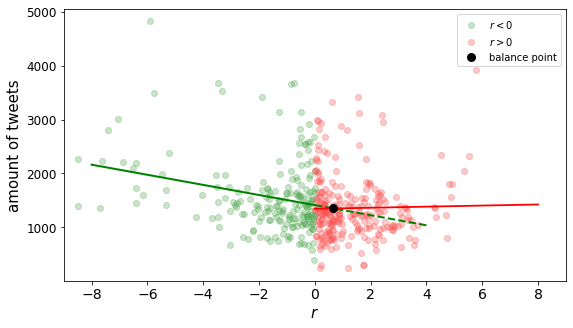

收益率为0： 1.0514553061004064
收益率为1： 1.1127157610662939
收益率为2： 1.1730729974525589
收益率为4： 1.2911565553735647
收益率为6： 1.405857823162038


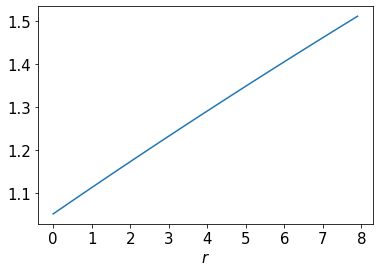

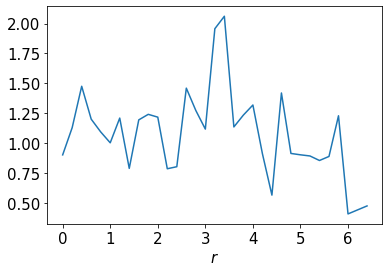

return > 0
[[Variables]]
    A1: -450135.535 +/- 2.1737e+09 (482903.44%) (init = 1000)
    A2:  1.0380e-04 +/- 0.52459768 (505394.40%) (init = 1)
    b:   451481.358 +/- 2.1737e+09 (481463.95%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -1.000
    C(A1, A2) = 1.000
    C(A2, b)  = -1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  23.3595794 +/- 40.6280769 (173.92%) (init = 93.58475)
    A2:  1.74240289 +/- 0.87733209 (50.35%) (init = 1.5)
    b:   1469.23506 +/- 67.8607682 (4.62%) (init = 1414.078)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.990
    C(A1, b)  = -0.678
    C(A2, b)  = 0.633


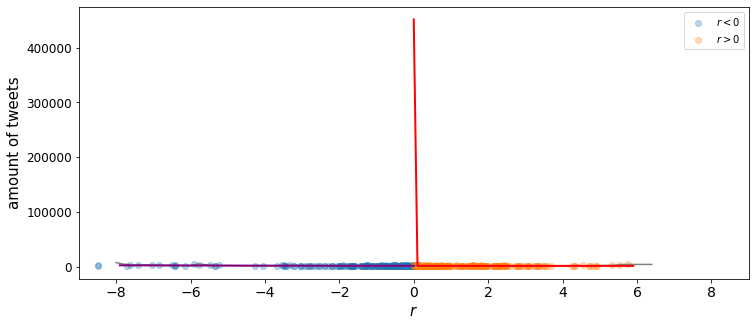

收益率为0.5： 1.0711134026141573
收益率为1： 1.1090578576052084
收益率为2： 1.1781283412496841
收益率为4： 1.3510458772356504
收益率为6： 1.5840997257455085


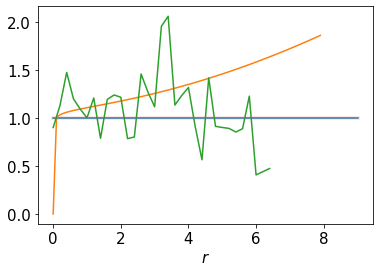

In [6]:
print("收益率与中原城市群")
x_n = olhc_urban.close[olhc_urban.close<0]
y_n = olhc_urban.Central_Plains[olhc_urban.close<0]
x = olhc_urban.close[olhc_urban.close>0]
y = olhc_urban.Central_Plains[olhc_urban.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与京津冀城市群
return > 0
---------- 收益率 < 0 ----------
相关性： -0.5033374060693906
参数： -728.6056187244242 5930.154167025932
R^2： 0.2533485443486627
[[Variables]]
    k: -728.605619 +/- 90.0354650 (12.36%) (init = 1000)
    b:  5930.15417 +/- 224.578401 (3.79%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.25470063502087054
参数： 407.75556952787485 5642.267544670854
R^2： 0.06487241348003459
[[Variables]]
    k:  407.755570 +/- 97.3296247 (23.87%) (init = -1000)
    b:  5642.26754 +/- 177.710655 (3.15%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.7868685878847708
平衡点： 0.25334077345411843


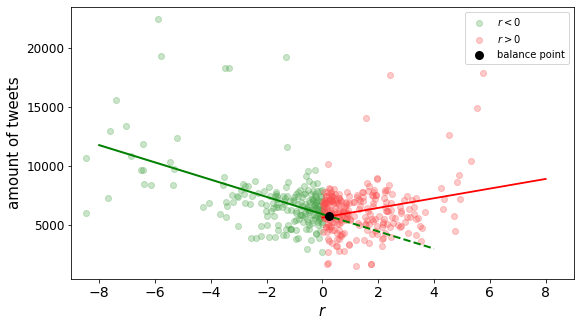

收益率为0： 1.0510232136416482
收益率为1： 1.1006172472503437
收益率为2： 1.143948370836973
收益率为4： 1.2160352271704453
收益率为6： 1.2735865214108932


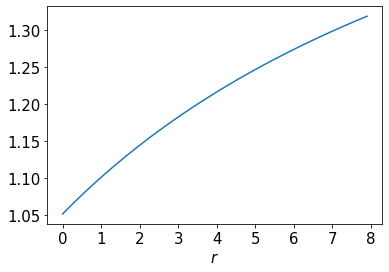

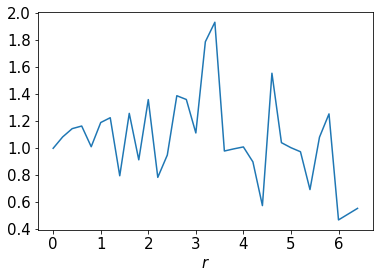

return > 0
[[Variables]]
    A1:  1.5081e-04 +/- 5.4508e-04 (361.43%) (init = 1000)
    A2:  10.3879865 +/- 2.10149270 (20.23%) (init = 1)
    b:   6038.81369 +/- 111.423261 (1.85%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.179
    C(A2, b)  = 0.175
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  476.631677 +/- 291.655696 (61.19%) (init = 728.6056)
    A2:  1.22007130 +/- 0.30807379 (25.25%) (init = 1.5)
    b:   6126.77862 +/- 313.723574 (5.12%) (init = 5930.154)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.980
    C(A1, b)  = -0.809
    C(A2, b)  = 0.746


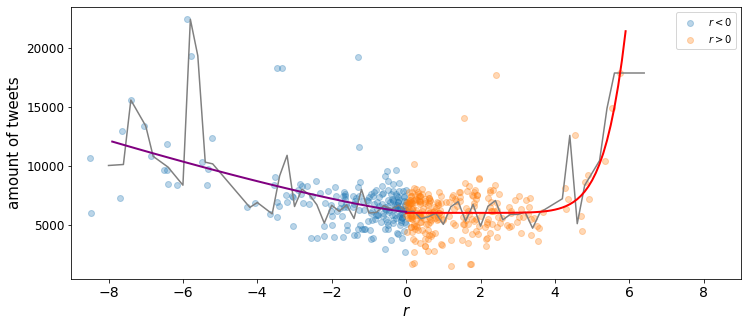

收益率为0.5： 1.0484473568736608
收益率为1： 1.0934945956623598
收益率为2： 1.198395833154963
收益率为4： 1.3809804419410752
收益率为6： 0.4264569237931604


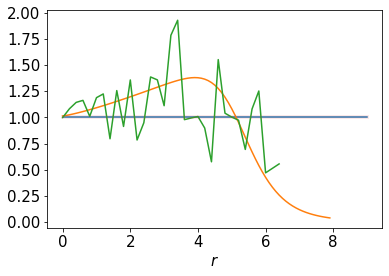

In [6]:
print("收益率与京津冀城市群")
x_n = olhc_urban.close[olhc_urban.close<0]
y_n = olhc_urban.Beijing_Tianjin_Hebei[olhc_urban.close<0]
x = olhc_urban.close[olhc_urban.close>0]
y = olhc_urban.Beijing_Tianjin_Hebei[olhc_urban.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与长三角城市群
return > 0
---------- 收益率 < 0 ----------
相关性： -0.3320351940364057
参数： -654.9861499538486 7502.240669896225
R^2： 0.1102473700787936
[[Variables]]
    k: -654.986150 +/- 133.938054 (20.45%) (init = 1000)
    b:  7502.24067 +/- 334.086061 (4.45%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.08250542661548768
参数： 205.34447307836854 6833.7933825354685
R^2： 0.00680714542100358
[[Variables]]
    k:  205.344473 +/- 155.939827 (75.94%) (init = -1000)
    b:  6833.79338 +/- 284.724912 (4.17%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -3.1896945660859197
平衡点： 0.7769655867936307


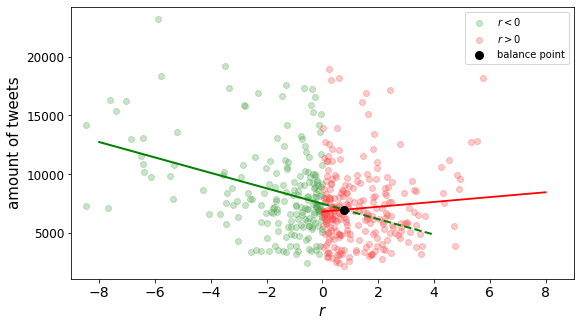

收益率为0： 1.097814968926197
收益率为1： 1.1588389071460705
收益率为2： 1.2164034046853323
收益率为4： 1.3222676418708028
收益率为6： 1.4173513123680086


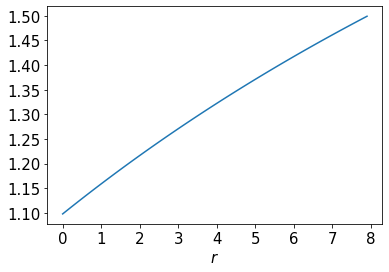

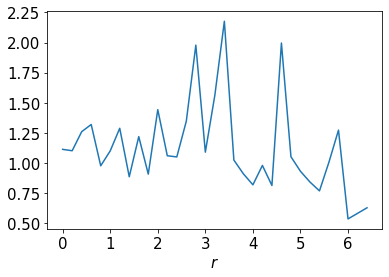

return > 0
[[Variables]]
    A1:  2.8578e-05 +/- 2.2025e-04 (770.70%) (init = 1000)
    A2:  11.2889993 +/- 4.46936521 (39.59%) (init = 1)
    b:   6981.94651 +/- 190.879644 (2.73%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.171
    C(A2, b)  = 0.167
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  233.972122 +/- 284.128490 (121.44%) (init = 654.9861)
    A2:  1.54555025 +/- 0.61566156 (39.83%) (init = 1.5)
    b:   7831.84804 +/- 393.511393 (5.02%) (init = 7502.241)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.987
    C(A1, b)  = -0.725
    C(A2, b)  = 0.674


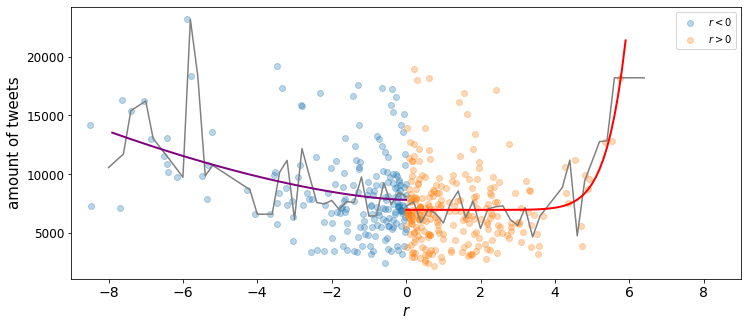

收益率为0.5： 1.1332081524983704
收益率为1： 1.155239461975609
收益率为2： 1.2195397720279282
收益率为4： 1.372126574924007
收益率为6： 0.47421594353485447


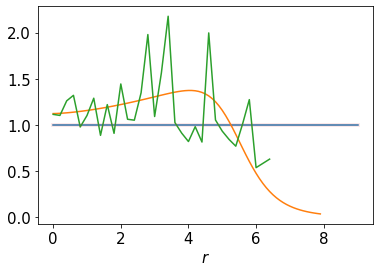

In [7]:
print("收益率与长三角城市群")
x_n = olhc_urban.close[olhc_urban.close<0]
y_n = olhc_urban.Yangtze_River_Delta[olhc_urban.close<0]
x = olhc_urban.close[olhc_urban.close>0]
y = olhc_urban.Yangtze_River_Delta[olhc_urban.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与珠三角城市群
return > 0
---------- 收益率 < 0 ----------
相关性： -0.46507275685348337
参数： -367.3739671574193 3738.6003482376495
R^2： 0.21629266916729895
[[Variables]]
    k: -367.373967 +/- 50.3368203 (13.70%) (init = 1000)
    b:  3738.60035 +/- 125.556774 (3.36%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.1549272881268652
参数： 148.19140124840536 3555.5986704600296
R^2： 0.024002464606344587
[[Variables]]
    k:  148.191401 +/- 59.4099501 (40.09%) (init = -1000)
    b:  3555.59867 +/- 108.474487 (3.05%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -2.479050498629201
平衡点： 0.35495339484007227


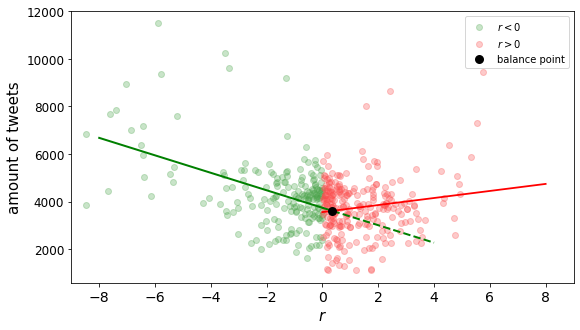

收益率为0： 1.0514685977632967
收益率为1： 1.1085872136109267
收益率为2： 1.1613109548833518
收益率为4： 1.2554577831277334
收益率为6： 1.3370488909624298


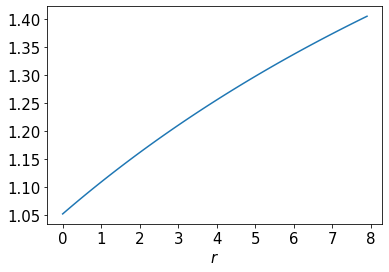

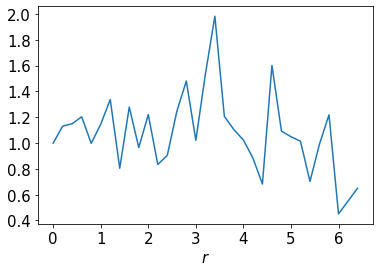

return > 0
[[Variables]]
    A1:  7.8930e-06 +/- 4.5560e-05 (577.22%) (init = 1000)
    A2:  11.6502773 +/- 3.34568086 (28.72%) (init = 1)
    b:   3690.08887 +/- 70.6546295 (1.91%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.168
    C(A2, b)  = 0.165
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  152.089085 +/- 118.861609 (78.15%) (init = 367.374)
    A2:  1.46444621 +/- 0.39366768 (26.88%) (init = 1.5)
    b:   3907.41754 +/- 153.026096 (3.92%) (init = 3738.6)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.985
    C(A1, b)  = -0.746
    C(A2, b)  = 0.692


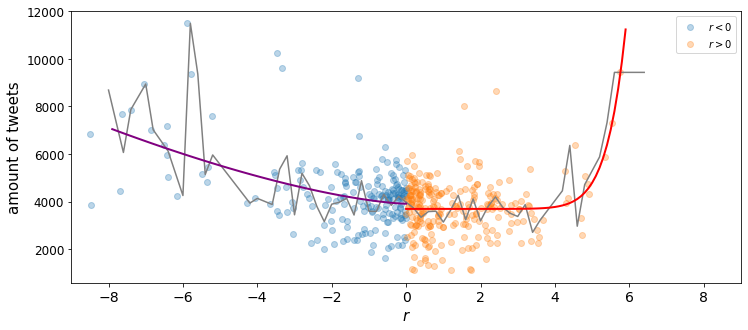

收益率为0.5： 1.0738307149249662
收益率为1： 1.100110800993301
收益率为2： 1.1726246218157064
收益率为4： 1.3430816401856147
收益率为6： 0.46650424623126907


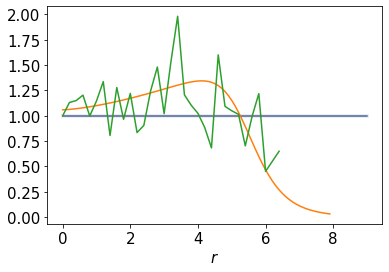

In [8]:
print("收益率与珠三角城市群")
x_n = olhc_urban.close[olhc_urban.close<0]
y_n = olhc_urban.Pearl_River_Delta[olhc_urban.close<0]
x = olhc_urban.close[olhc_urban.close>0]
y = olhc_urban.Pearl_River_Delta[olhc_urban.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与长江中游城市群
return > 0
---------- 收益率 < 0 ----------
相关性： -0.37438017304800986
参数： -217.98705732430102 2426.9945659587493
R^2： 0.1401605139714579
[[Variables]]
    k: -217.987057 +/- 38.8640365 (17.83%) (init = 1000)
    b:  2426.99457 +/- 96.9398353 (3.99%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.1929047888438872
参数： 152.99469081943644 2350.9056651953915
R^2： 0.03721225755890489
[[Variables]]
    k:  152.994691 +/- 48.9258487 (31.98%) (init = -1000)
    b:  2350.90567 +/- 89.3319434 (3.80%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.4248014500161201
平衡点： 0.20510146696995177


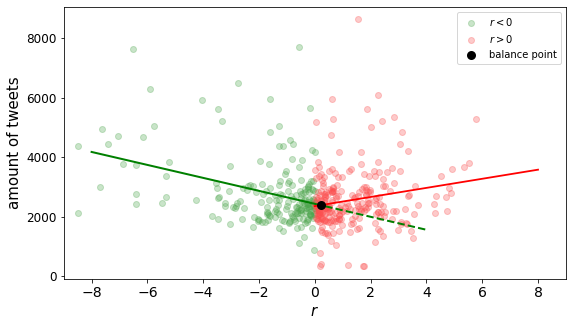

收益率为0： 1.032365782213143
收益率为1： 1.056344601305447
收益率为2： 1.0775618269222291
收益率为4： 1.11342270510227
收益率为6： 1.1425699267897331


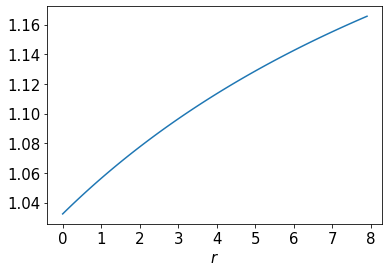

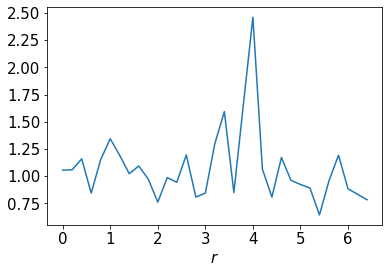

return > 0
[[Variables]]
    A1:  89.7946317 +/- 113.610567 (126.52%) (init = 1000)
    A2:  1.36182568 +/- 0.82798541 (60.80%) (init = 1)
    b:   2395.92639 +/- 113.538581 (4.74%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.968
    C(A1, b)  = -0.806
    C(A2, b)  = 0.717
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  141.452211 +/- 125.331934 (88.60%) (init = 217.9871)
    A2:  1.22406722 +/- 0.44669277 (36.49%) (init = 1.5)
    b:   2486.81481 +/- 135.196047 (5.44%) (init = 2426.995)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.980
    C(A1, b)  = -0.808
    C(A2, b)  = 0.745


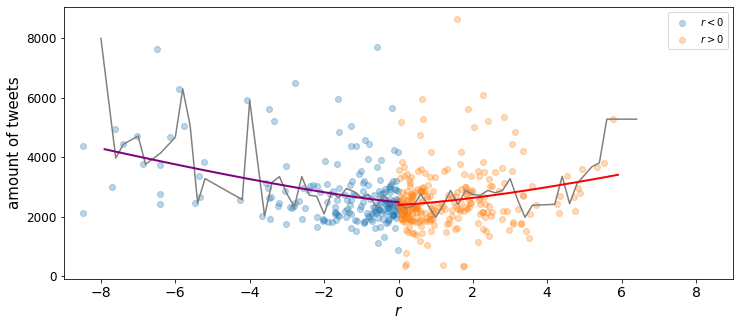

收益率为0.5： 1.047926283846695
收益率为1： 1.057345936136192
收益率为2： 1.0725415995467955
收益率为4： 1.0902209170260342
收益率为6： 1.0959091072021565


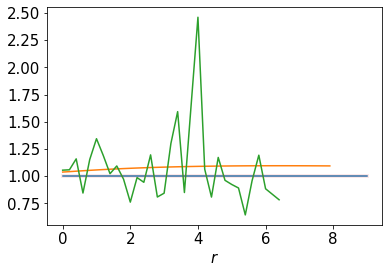

In [9]:
print("收益率与长江中游城市群")
x_n = olhc_urban.close[olhc_urban.close<0]
y_n = olhc_urban.Middle_Reaches_of_Yangtze_River[olhc_urban.close<0]
x = olhc_urban.close[olhc_urban.close>0]
y = olhc_urban.Middle_Reaches_of_Yangtze_River[olhc_urban.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass

收益率与成渝城市群
return > 0
---------- 收益率 < 0 ----------
相关性： -0.5602283853952863
参数： -184.09280165959353 933.0087833286976
R^2： 0.31385584380260956
[[Variables]]
    k: -184.092802 +/- 19.5929905 (10.64%) (init = 1000)
    b:  933.008783 +/- 48.8714361 (5.24%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.658
---------- 收益率 > 0 ----------
相关性： 0.37593526209244194
参数： 126.7289303104151 853.1424270949146
R^2： 0.14132732128451286
[[Variables]]
    k:  126.728930 +/- 19.6388596 (15.50%) (init = -1000)
    b:  853.142427 +/- 35.8578862 (4.20%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.734
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.4526501660565507
平衡点： 0.2569522913587308


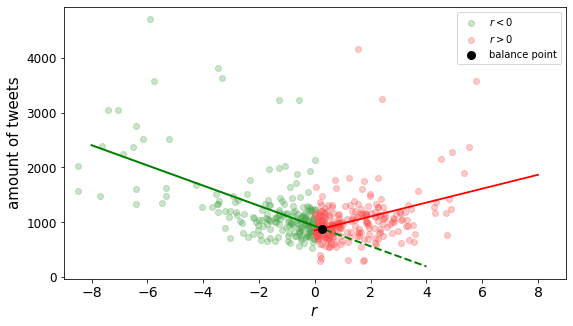

收益率为0： 1.0936143294452494
收益率为1： 1.1400492284480515
收益率为2： 1.1758485887743828
收益率为4： 1.2274328064640576
收益率为6： 1.2628108937096068


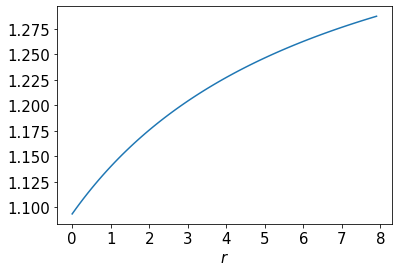

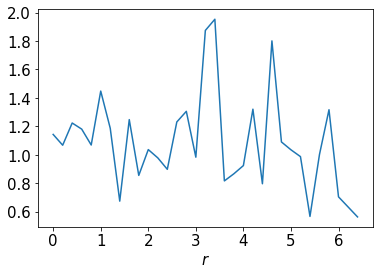

return > 0
[[Variables]]
    A1: -1759591.38 +/- 2.7347e+09 (155415.27%) (init = 1000)
    A2: -5.0617e-05 +/- 0.08135273 (160722.91%) (init = 1)
    b:   1760638.29 +/- 2.7347e+09 (155322.86%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -1.000
    C(A2, b)  = 1.000
    C(A1, A2) = -1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  109.514926 +/- 59.4685682 (54.30%) (init = 184.0928)
    A2:  1.27000471 +/- 0.27352820 (21.54%) (init = 1.5)
    b:   991.333501 +/- 66.0981070 (6.67%) (init = 933.0088)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.981
    C(A1, b)  = -0.796
    C(A2, b)  = 0.735


<ipython-input-3-93145fc6712b>:3: RuntimeWarning: divide by zero encountered in power
  return p['A1'] * (x ** p['A2']) + p['b']


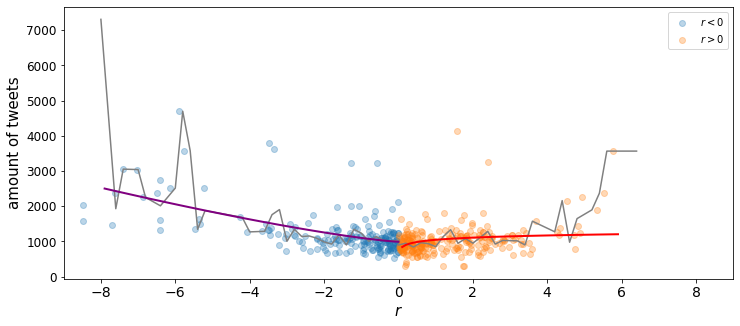

收益率为0.5： 1.0523388460994145
收益率为1： 1.0515138891993265
收益率为2： 1.1324047245608275
收益率为4： 1.3912231762844354
收益率为6： 1.7051605343294514


<ipython-input-3-93145fc6712b>:3: RuntimeWarning: divide by zero encountered in power
  return p['A1'] * (x ** p['A2']) + p['b']


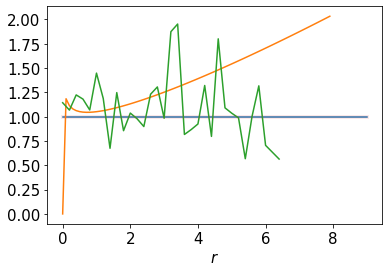

In [10]:
print("收益率与成渝城市群")
x_n = olhc_urban.close[olhc_urban.close<0]
y_n = olhc_urban.Chengdu_Chongqing[olhc_urban.close<0]
x = olhc_urban.close[olhc_urban.close>0]
y = olhc_urban.Chengdu_Chongqing[olhc_urban.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')
pass